---
# CARREGAR DATASET
---

In [11]:
import numpy as np
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
import statistics
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, KFold, train_test_split,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
#from tensorflow.keras.models  import Sequential
#from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

RANDOM_SEED = 2022

In [12]:
df = pd.read_csv('cardio_train.csv', sep=";")

---
# EXPLORAÇÃO DE DADOS
---

## <u>Atributos</u>
- id: Identificação da entrada. Não relevante.
- age: Idade (em dias) do paciente
- gender: Gênero sexual do paciente (1 - Mulher / 2 - Homem)
- height: Altura do paciente (em centimetros)
- weight: Peso do paciente (em quilogramas)
- ap_hi: Pressão arterial sistólica. Valor máximo da pressão que o sangue exerce sobre as paredes das artérias
- ap_lo: Pressão arterial diastólica. Valor mínimo da pressão que o sangue exerce sobre as paredes das artérias
- cholesterol: Valor de colesterol. (1 - Normal / 2 - Acima do normal / 3 - Muito acima do normal)
- gluc: Nível de glucose. (1 - Normal / 2 - Acima do normal / 3 - Muito acima do normal)
- smoke: Se o paciente é fumador (0 - Falso / 1 - Verdadeiro)
- alco: Se o paciente ingere álcool (0 - Falso / 1 - Verdadeiro)
- active: Se o paciente pratica desporto (0 - Falso / 1 - Verdadeiro)
- cardio: Atributo objetivo. Indica se o paciente possui uma doença cardiovascular  (0 - Falso / 1 - Verdadeiro)

In [13]:
# Quais são os atributos e os seus tipos, e qual a quantidade de 'missing values'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [14]:
#Remocao da coluna id (É irrelevante)
df.drop('id', axis=1, inplace=True)

## <u>Tipos de valores</u>
Esta subsecção serve para:
- Verificar a discrepância entre a quantidade de amostras associadas às categorias de um atributo (pode levar a overfit)
- Identificação de valores que não deveriam existir

#### Atributos categóricos


In [15]:
'''
Género (deve ser binária)

BIASED
'''

df['gender'].value_counts(normalize=True)

1    0.650429
2    0.349571
Name: gender, dtype: float64

In [16]:
'''
Colesterol (deve ser ternária):
    -> 1: normal
    -> 2: acima do normal
    -> 3: bem acima do normal

BIASED
'''
df['cholesterol'].value_counts(normalize=True)

1    0.748357
2    0.136414
3    0.115229
Name: cholesterol, dtype: float64

In [17]:
'''
Glucose (deve ser ternária):
    -> 1: normal
    -> 2: acima do normal
    -> 3: bem acima do normal

BIASED
'''
df['gluc'].value_counts(normalize=True)

1    0.849700
3    0.076157
2    0.074143
Name: gluc, dtype: float64

In [18]:
'''
É fumador (deve ser binária):
    -> 0: não
    -> 1: sim

BIASED
'''
df['smoke'].value_counts(normalize=True)

0    0.911871
1    0.088129
Name: smoke, dtype: float64

In [19]:
'''
Ingere álcool (deve ser binária):
    -> 0: não
    -> 1: sim

BIASED
'''
df['alco'].value_counts(normalize=True)

0    0.946229
1    0.053771
Name: alco, dtype: float64

In [20]:
'''
Pratica desporto (deve ser binária):
    -> 0: não
    -> 1: sim

BIASED
'''
df['active'].value_counts(normalize=True)

1    0.803729
0    0.196271
Name: active, dtype: float64

In [21]:
'''
Presença de doença cardio vascular [Variável objetivo] (deve ser binária):
    -> 0: não
    -> 1: sim
'''
df['cardio'].value_counts(normalize=True)

0    0.5003
1    0.4997
Name: cardio, dtype: float64

#### Atributos contínuos

In [22]:
def get_outliers_zscore(frame : pd.DataFrame, column : str, thresh : int):
    media = frame[column].mean()
    std = frame[column].std()
    col = frame[column]

    z_scores = (col - media) / std
    outliers = z_scores.abs().loc[z_scores > thresh].index
    return frame.loc[outliers]

In [23]:
def get_limits_iqr(frame : pd.DataFrame, column : str):
    q1 = frame[column].quantile(0.25)
    q3 = frame[column].quantile(0.75)
    iqr = q3-q1
    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5*iqr
    return lim_inf, lim_sup

def get_outliers_iqr(frame : pd.DataFrame, column : str):
    lim_inf, lim_sup = get_limits_iqr(frame, column)
    return frame.loc[(frame[column] < lim_inf) | (frame[column] > lim_sup)]

'\nConclusões: ...\n\n'

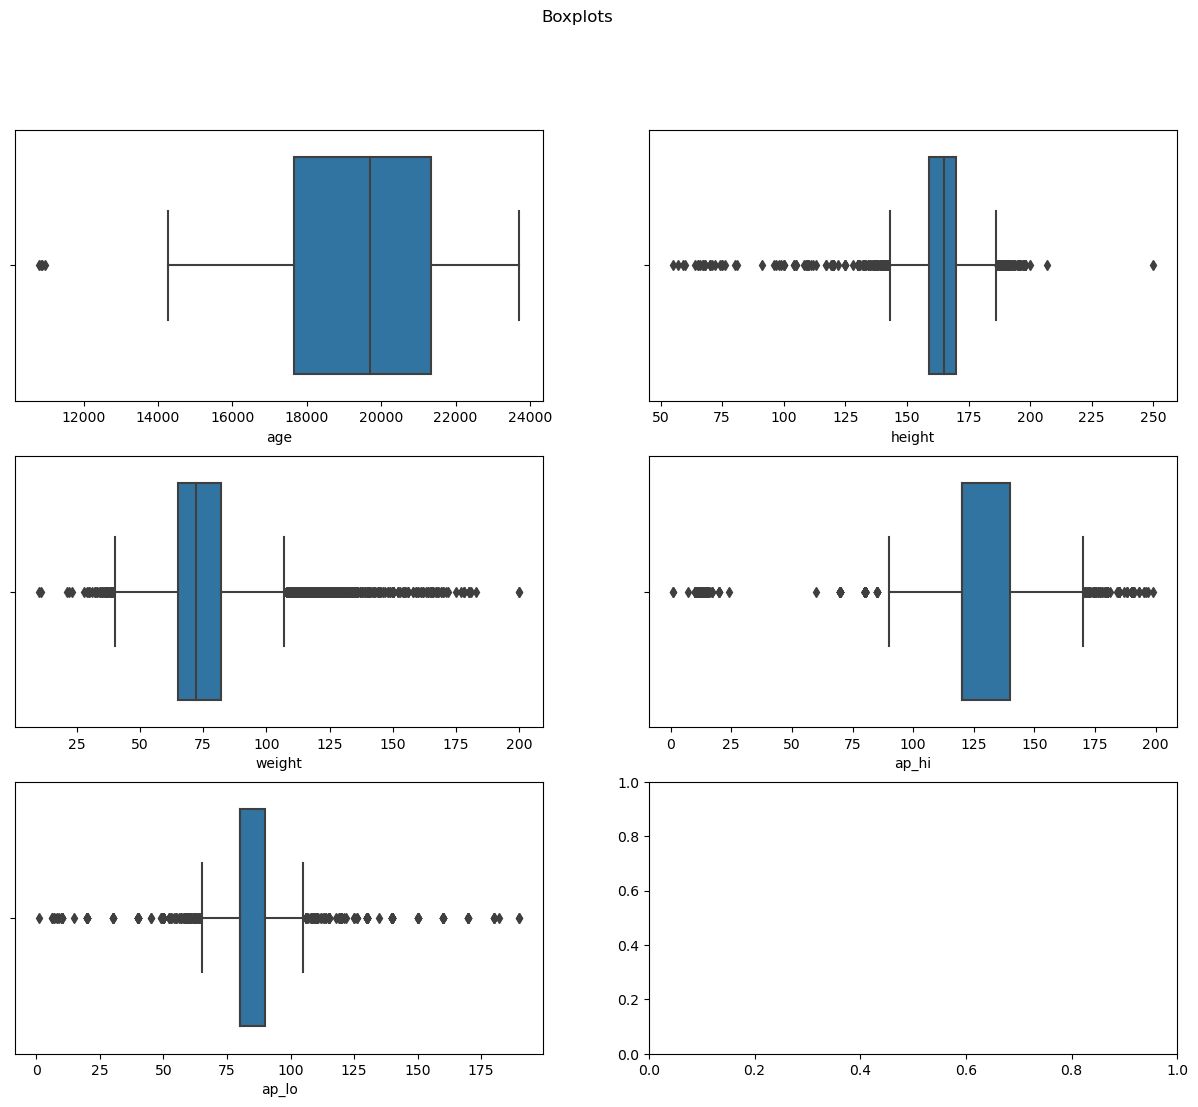

In [24]:
#Boxplots para visualização de outliers
fig, axs = plt.subplots(3,2, figsize = (15,12))
fig.suptitle("Boxplots")
sns.boxplot(x=df['age'], ax=axs[0,0])
sns.boxplot(x=df['height'], ax=axs[0,1])
sns.boxplot(x=df['weight'], ax=axs[1,0])
sns.boxplot(x=df['ap_hi'].loc[(df['ap_hi'] > 0) & (df['ap_hi'] < 200)], ax=axs[1,1])
sns.boxplot(x=df['ap_lo'].loc[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)], ax=axs[2,0])

'''
Conclusões: ...

'''

<AxesSubplot:xlabel='ap_lo', ylabel='Count'>

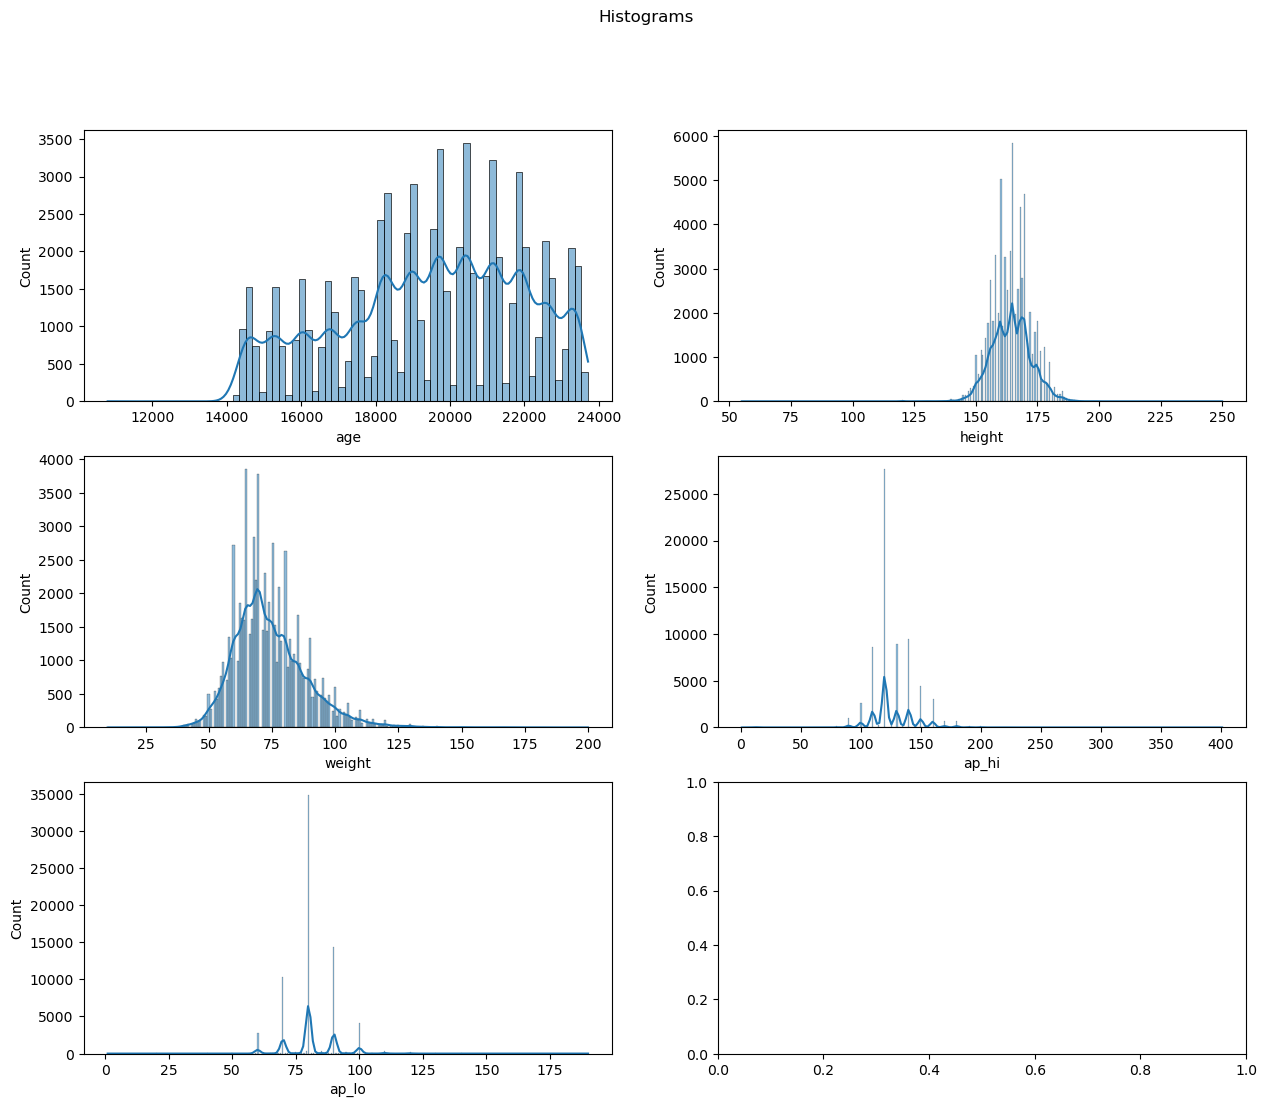

In [25]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
fig.suptitle("Histograms")
sns.histplot(df["age"], ax=axs[0,0], kde=True)
sns.histplot(df["height"], ax=axs[0,1], kde=True)
sns.histplot(df["weight"], ax=axs[1,0], kde=True)
sns.histplot(df["ap_hi"].loc[(df["ap_hi"] > 0) & (df["ap_hi"] < 500)], ax=axs[1,1], kde=True) # plot com apenas valores acima de 0 e abaixo de 500 para ser possível observar melhor o comportamento dos dados (mesmo com esta restricao ainda existem valores (outliers) impossiveis)
sns.histplot(df["ap_lo"].loc[(df["ap_lo"] > 0) & (df["ap_lo"] < 500)], ax=axs[2,0], kde=True) # plot com apenas valores  acima de 0 e abaixo de 500 para ser possível observar melhor o comportamento dos dados (mesmo com esta restricao ainda existem valores (outliers) impossiveis)

## <u>Tendência Central</u>

In [26]:
#Média, desvio padrão, percentis, mínimo e máximo
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
#Mediana
df.median()

age            19703.0
gender             1.0
height           165.0
weight            72.0
ap_hi            120.0
ap_lo             80.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
cardio             0.0
dtype: float64

In [28]:
#Moda
df.mode().iloc[0]

age            18236.0
gender             1.0
height           165.0
weight            65.0
ap_hi            120.0
ap_lo             80.0
cholesterol        1.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
cardio             0.0
Name: 0, dtype: float64

In [29]:
print(f"Skewness: \n{df.skew()}")
print(f"\nKurtosis: \n{df.kurt()}")

Skewness: 
age            -0.307055
gender          0.630960
height         -0.642187
weight          1.012070
ap_hi          85.296214
ap_lo          32.114083
cholesterol     1.587123
gluc            2.397462
smoke           2.905867
alco            3.956607
active         -1.529473
cardio          0.001200
dtype: float64

Kurtosis: 
age              -0.823447
gender           -1.601935
height            7.943653
weight            2.586825
ap_hi          7580.074738
ap_lo          1425.914585
cholesterol       0.993901
gluc              4.294377
smoke             6.444250
alco             13.655125
active            0.339296
cardio           -2.000056
dtype: float64


## <u>Correlação entre atributos</u>

<AxesSubplot:>

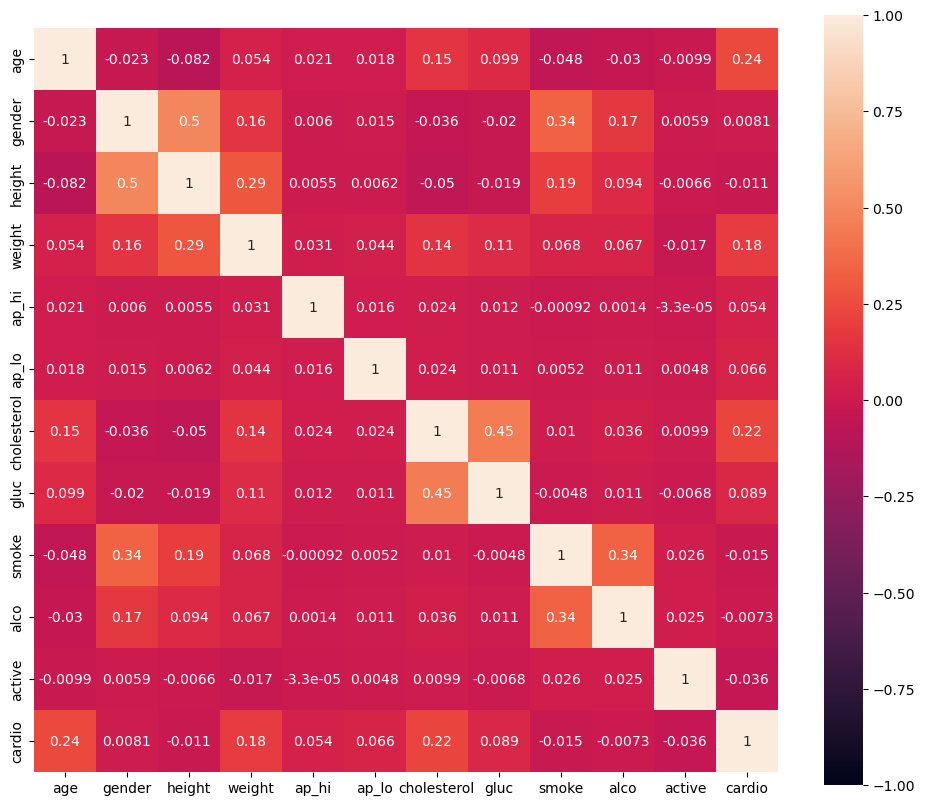

In [30]:
corr_matrix = df.corr()
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

---
# TRATAMENTO DE DADOS
---

In [31]:
#Entradas duplicadas
print("Nº de entradas duplicadas: ", df.duplicated().sum())

Nº de entradas duplicadas:  24


## Remoção de entradas consideradas impossíveis

In [32]:
#Entradas cujo valor diastólico é superior ao sistólico
df.loc[df['ap_hi'] < df['ap_lo']]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
228,17489,2,183,98.0,160,1100,1,2,1,0,1,1
241,21932,2,157,60.0,160,1000,2,1,0,0,0,1
260,18217,1,150,83.0,140,800,1,1,0,0,1,1
329,23407,1,176,63.0,160,1000,2,2,0,0,0,1
345,18704,1,154,81.0,140,1000,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
69771,23330,1,167,81.0,160,1000,1,1,0,0,1,1
69872,21808,1,152,56.0,160,1000,1,1,0,0,1,1
69878,21239,2,168,95.0,160,1000,1,1,0,0,1,1
69885,22417,2,166,78.0,170,1000,1,1,0,0,0,0


In [33]:
# Remoção das entradas cujo valor diastólico é superior ao sistólico
df.drop(df.loc[df['ap_hi'] < df['ap_lo']].index, inplace=True)

## Tratamento de outliers

### Remoção de outliers

In [34]:
# FILTRAR POR VALORES NORMAIS
df.drop(df.loc[(df['height'] < 130) | (df['height'] > 210)].index, inplace=True)
df.drop(df.loc[df['weight'] < 40].index, inplace=True)
df.drop(df.loc[(df['ap_hi'] > 360) | (df['ap_hi'] < 30)].index, inplace=True)
df.drop(df.loc[(df['ap_lo'] > 250) | (df['ap_lo'] < 30)].index, inplace=True)

In [35]:
#Nº de outliers utilizando IQR
for attr in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    print(f"Nr de outliers da feature '{attr}': {get_outliers_iqr(df,attr).shape[0]}")

Nr de outliers da feature 'age': 4
Nr de outliers da feature 'height': 411
Nr de outliers da feature 'weight': 1688
Nr de outliers da feature 'ap_hi': 1007
Nr de outliers da feature 'ap_lo': 3495


In [36]:
#Nº de outliers com z-score igual ou superior a 3
for attr in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    print(f"Nr de outliers da feature '{attr}': {get_outliers_zscore(df,attr,3).shape[0]}")

Nr de outliers da feature 'age': 0
Nr de outliers da feature 'height': 183
Nr de outliers da feature 'weight': 705
Nr de outliers da feature 'ap_hi': 894
Nr de outliers da feature 'ap_lo': 626


In [37]:
#Remocao de outliers com z-score igual ou superior a 3
for attr in ['age', 'height', 'weight', 'ap_hi', 'ap_lo']:
    df.drop(get_outliers_zscore(df, attr, 3).index)

### Modificação de outliers

In [38]:
def convert_outlier_to_limit(val, lim_inf, lim_sup):
    counter = 0
    if val < lim_inf:
        return lim_inf
    elif val > lim_sup:
        return lim_sup
    else:
        return val

##### - Age

In [39]:
# Modifica valores dos outliers para o limite mais proximo
linf, lsup = get_limits_iqr(df, 'age')
df['age'] = df['age'].apply(convert_outlier_to_limit,args=(linf,lsup))

<AxesSubplot:xlabel='age'>

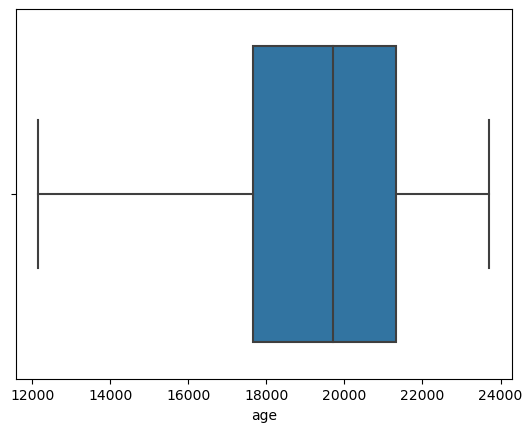

In [40]:
sns.boxplot(x=df['age'])

##### - Pressão diastólica e sistólica

In [41]:
# Modifica valores dos outliers para o limite mais proximo
linf, lsup = get_limits_iqr(df, 'ap_lo')
df['ap_lo'] = df['ap_lo'].apply(convert_outlier_to_limit,args=(linf,lsup))

In [42]:
# Modifica valores dos outliers para o limite mais proximo
linf, lsup = get_limits_iqr(df, 'ap_hi')
df['ap_hi'] = df['ap_hi'].apply(convert_outlier_to_limit,args=(linf,lsup))

In [43]:
# Remoção das entradas cujo valor diastólico é superior ao sistólico
df.drop(df.loc[df['ap_hi'] < df['ap_lo']].index, inplace=True)

<AxesSubplot:xlabel='ap_lo'>

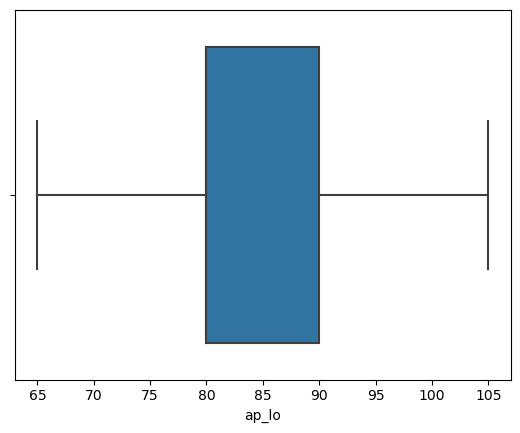

In [44]:
sns.boxplot(x=df['ap_lo'])

<AxesSubplot:xlabel='ap_hi'>

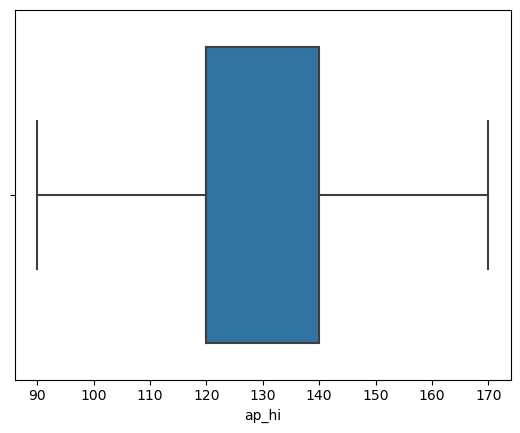

In [45]:
sns.boxplot(x=df['ap_hi'])

## Feature Engineering

### Conversão da altura de centimetros para metros

In [46]:
df['height'] = df['height'] / 100

### Conversão da idade em dias para idade em anos

In [47]:
import math

def calculate_age(days):
    return math.floor(days / 365.0)

In [48]:
df['age'] = df['age'].apply(calculate_age)

### Binning da idade

In [49]:
def bin_age(age):
    if age < 30:
        return 1
    elif age < 40:
        return 2
    elif age < 50:
        return 3
    elif age < 60:
        return 4
    else:
        return 5

In [50]:
df['age_binned'] = df['age'].apply(bin_age)

### Criação do atributo BMI (Indice de massa corporal)

In [51]:
# BMI = weight / height^2
df['BMI'] = df.weight / (df.height * df.height)

<AxesSubplot:xlabel='BMI'>

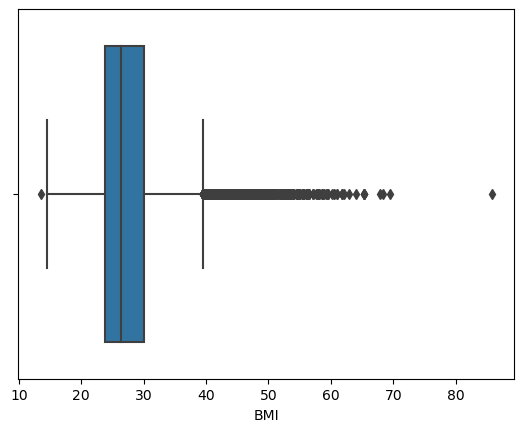

In [52]:
sns.boxplot(x=df["BMI"])

In [53]:
#Remocao de outliers do atributo BMI
df = df.drop(get_outliers_iqr(df, 'BMI').index)
#df = df.drop(df.loc[df['BMI'] > 50].index)

## <u>Seleção de atributos</u>

In [54]:
#Em funcao da nova altura, retorna o peso que mantem o bmi
def modify_height(new_height, bmi):
    return bmi * new_height * new_height

#Em funcao do novo peso, retorna a altura que mantem o bmi
def modify_weight(new_weight, bmi):
    return math.sqrt(new_weight / bmi)

def modify_height_weight_bmi_outliers(frame : pd.DataFrame):
    counter_height = 0
    counter_weight = 0
    linf_height, lsup_height = get_limits_iqr(df, 'height')
    linf_weight, lsup_weight = get_limits_iqr(df, 'weight')
    for index,row in frame.iterrows():
        height = row["height"]
        weight = row["weight"]
        new_height = convert_outlier_to_limit(height, linf_height, lsup_height)
        new_weight = convert_outlier_to_limit(weight, linf_weight, lsup_weight)
        if height != new_height :
            df.at[index, "height"] = new_height
            counter_height = counter_height + 1
        if weight != new_weight :
            df.at[index, "weight"] = new_weight
            counter_weight = counter_weight + 1
    print(f"height: {counter_height} | weight:{counter_weight}")

In [55]:
modify_height_weight_bmi_outliers(df)

height: 369 | weight:1471


<AxesSubplot:xlabel='BMI'>

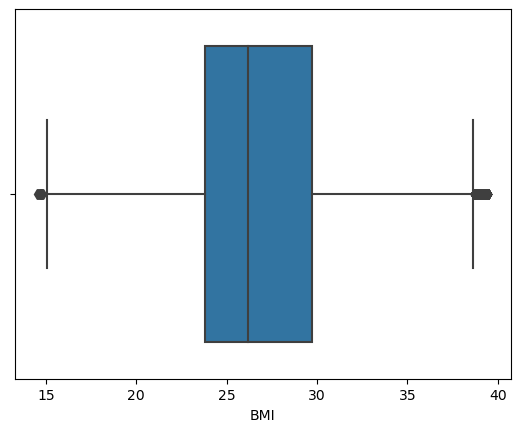

In [56]:
sns.boxplot(x=df["BMI"])

<AxesSubplot:xlabel='height'>

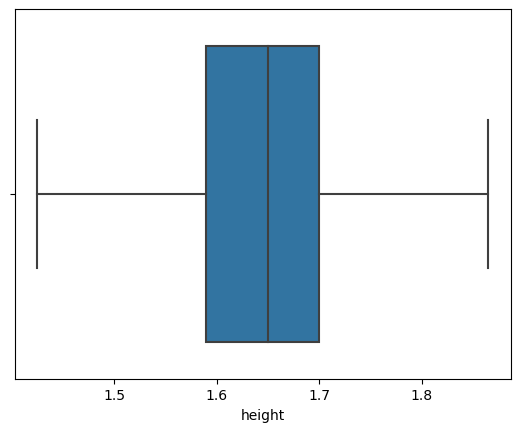

In [57]:
sns.boxplot(x=df["height"])

<AxesSubplot:xlabel='weight'>

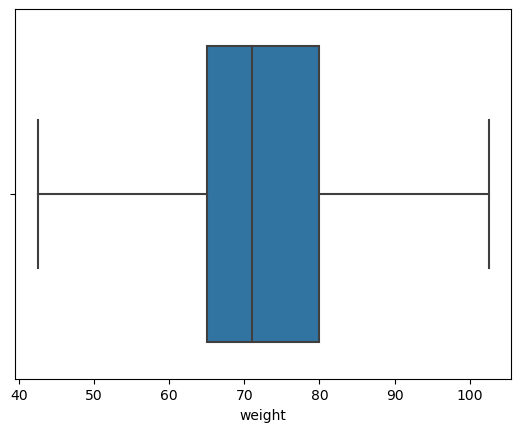

In [58]:
sns.boxplot(x=df["weight"])

### Binning do indice de massa corporal

In [59]:
def bin_bmi(bmi):
    if bmi < 18.5: # underweight
        return 1
    elif bmi < 25: # normal
        return 2
    elif bmi < 30: # overweight
        return 3
    elif bmi < 35: # obese
        return 4
    else:          # extremely obese
        return 5

In [60]:
df['BMI_binned'] = df['BMI'].apply(bin_bmi)

In [61]:
print(f"Skewness: \n{df.skew()}")
print(f"\nKurtosis: \n{df.kurt()}")

Skewness: 
age           -0.298288
gender         0.605189
height         0.105615
weight         0.361235
ap_hi          0.648458
ap_lo          0.355303
cholesterol    1.630408
gluc           2.447111
smoke          2.885160
alco           3.976999
active        -1.533508
cardio         0.043996
age_binned    -0.136311
BMI            0.566920
BMI_binned     0.606701
dtype: float64

Kurtosis: 
age            -0.829595
gender         -1.633795
height         -0.091919
weight         -0.260973
ap_hi           0.415400
ap_lo           0.077090
cholesterol     1.145101
gluc            4.541215
smoke           6.324341
alco           13.816939
active          0.351657
cardio         -1.998124
age_binned     -0.429093
BMI            -0.119230
BMI_binned     -0.372507
dtype: float64


<AxesSubplot:xlabel='BMI'>

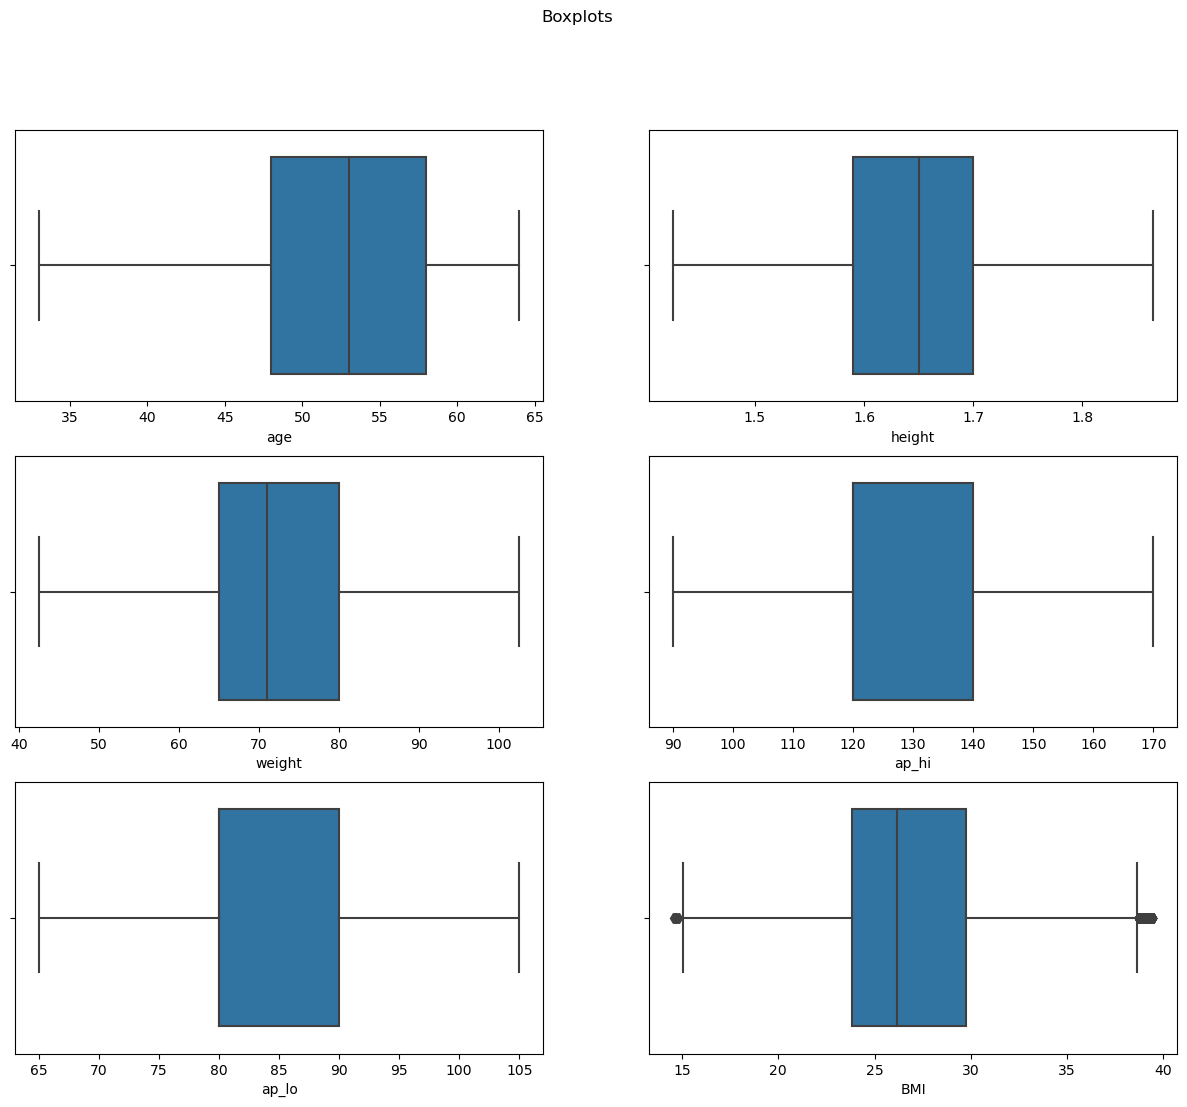

In [62]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
fig.suptitle("Boxplots")
sns.boxplot(x=df['age'], ax=axs[0,0])
sns.boxplot(x=df['height'], ax=axs[0,1])
sns.boxplot(x=df['weight'], ax=axs[1,0])
sns.boxplot(x=df['ap_hi'], ax=axs[1,1])
sns.boxplot(x=df['ap_lo'], ax=axs[2,0])
sns.boxplot(x=df['BMI'], ax=axs[2,1])

## <u>Seleção de atributos</u>

In [63]:
#Seleção por correlação
cor = df.corr()
cor_target = abs(cor["cardio"])
relevant_features = cor_target[cor_target > 0.2]
relevant_features.index

Index(['age', 'ap_hi', 'ap_lo', 'cholesterol', 'cardio', 'age_binned'], dtype='object')

In [64]:
x = df.drop(['cardio', 'weight', 'height','age','BMI'], axis=1)
y = df['cardio'].to_frame()

uni = SelectKBest(score_func = f_classif, k = 10)
fit = uni.fit(x, y) 
x.columns[fit.get_support(indices=True)].tolist()

/home/francisco/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['gender',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active',
 'age_binned',
 'BMI_binned']

---
# MODELOS
---

## Decision Tree Classifier

In [65]:
x = df.drop(['cardio', 'weight', 'height', 'BMI'], axis=1)
y = df['cardio'].to_frame()

In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(random_state=2022, criterion='gini', max_depth=10)
scores = cross_val_score(clf, x, y, cv=10)
print(scores)
print('RESULT: %0.2f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))
print(scores.mean())

[0.72410687 0.72966076 0.73626539 0.73701591 0.72095467 0.72856928
 0.72796877 0.73592554 0.72676775 0.72796877]
RESULT: 0.73 accuracy with a standard deviation of 0.01
0.7295203722623853


In [67]:
from sklearn.model_selection import train_test_split

best_accuracy = 0
best_criterion = ""
best_max_depth = 0

for i in range(1,10):
    for c in ["gini","entropy"]:
        clf = DecisionTreeClassifier(random_state=2022, criterion=c, max_depth=i)
        scores = cross_val_score(clf, x, y, cv=10)
        new_acc = scores.mean()
        if new_acc > best_accuracy:
            best_accuracy = new_acc
            best_criterion = c
            best_max_depth = i

print("Best accuracy:", best_accuracy)
print("best_criterion:", best_criterion)
print("best_max_depth:", best_max_depth)

Best accuracy: 0.7327778979890336
best_criterion: gini
best_max_depth: 7


## MultiLayer Perceptron Model

In [68]:
x = df.drop(["cardio","BMI_binned","age_binned"],axis=1)
y = df[["cardio"]]

scaler_x = MinMaxScaler(feature_range=(0,1)).fit(x)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y)
x_scaled = pd.DataFrame(scaler_x.transform(x[x.columns]),columns=x.columns)
y_scaled = pd.DataFrame(scaler_y.transform(y[y.columns]),columns=y.columns)

In [69]:
x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI
0,50,2,1.68,62.0,110.0,80.0,1,1,0,0,1,21.967120
1,55,1,1.56,85.0,140.0,90.0,3,1,0,0,1,34.927679
2,51,1,1.65,64.0,130.0,70.0,3,1,0,0,0,23.507805
3,48,2,1.69,82.0,150.0,100.0,1,1,0,0,1,28.710479
4,47,1,1.56,56.0,100.0,65.0,1,1,0,0,0,23.011177


In [70]:
x_scaled.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI
0,0.548387,1.0,0.579545,0.325000,0.250,0.375,0.0,0.0,0.0,0.0,1.0,0.298193
1,0.709677,0.0,0.306818,0.708333,0.625,0.625,1.0,0.0,0.0,0.0,1.0,0.817666
2,0.580645,0.0,0.511364,0.358333,0.500,0.125,1.0,0.0,0.0,0.0,0.0,0.359945
3,0.483871,1.0,0.602273,0.658333,0.750,0.875,0.0,0.0,0.0,0.0,1.0,0.568474
4,0.451613,0.0,0.306818,0.225000,0.125,0.000,0.0,0.0,0.0,0.0,0.0,0.340040


In [71]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=RANDOM_SEED)

In [72]:
def build_model(activation="relu",learning_rate=0.01):
    #Create a sequential
    model = Sequential()
    model.add(Dense(16, input_dim=12, activation=activation))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation="relu"))

    #Compile the model
    #
    model.compile(
        loss="mae",
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ["mae","mse"])
    return model

In [73]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


2022-12-18 12:13:21.775150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 12:13:21.775754: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [74]:
model.summary()
TUNING_DICT = {
    "activation": ["relu", "sigmoid"],
    "learning_rate": [0.02, 0.001]
}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [75]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=5,batch_size=5)
grid_search = GridSearchCV(estimator=model,
                           param_grid= TUNING_DICT,
                           cv = kf,
                           scoring="neg_mean_absolute_error",
                           refit="True",
                           verbose = 1)

grid_search.fit(x_train,y_train,validation_split=0.2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/tmp/ipykernel_15358/349892852.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=5,batch_size=5)


Epoch 1/5
6822/6822 [==============================] - 40s 6ms/step - loss: 0.4856 - mae: 0.4856 - mse: 0.4856 - val_loss: 0.4977 - val_mae: 0.4977 - val_mse: 0.4977
Epoch 2/5
6822/6822 [==============================] - 36s 5ms/step - loss: 0.4856 - mae: 0.4856 - mse: 0.4856 - val_loss: 0.4977 - val_mae: 0.4977 - val_mse: 0.4977
Epoch 3/5
6822/6822 [==============================] - 33s 5ms/step - loss: 0.4856 - mae: 0.4856 - mse: 0.4856 - val_loss: 0.4977 - val_mae: 0.4977 - val_mse: 0.4977
Epoch 4/5
6822/6822 [==============================] - 35s 5ms/step - loss: 0.4856 - mae: 0.4856 - mse: 0.4856 - val_loss: 0.4977 - val_mae: 0.4977 - val_mse: 0.4977
Epoch 5/5
2132/2132 [==============================] - 10s 4ms/step
Epoch 1/5
6822/6822 [==============================] - 37s 5ms/step - loss: 0.3153 - mae: 0.3153 - mse: 0.2730 - val_loss: 0.2927 - val_mae: 0.2927 - val_mse: 0.2592
Epoch 2/5
6822/6822 [==============================] - 38s 6ms/step - loss: 0.2918 - mae: 0.2918 - mse

GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa0981289d0>,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'learning_rate': [0.02, 0.001]},
             refit='True', scoring='neg_mean_absolute_error', verbose=1)

In [76]:
print("Best : %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_["mean_test_score"]
stds = grid_search.cv_results_["std_test_score"]
params = grid_search.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print("%f  (%f) with: %r" % (mean, stdev, param))

Best : -0.278164 using {'activation': 'relu', 'learning_rate': 0.001}
-0.415886  (0.091217) with: {'activation': 'relu', 'learning_rate': 0.02}
-0.278164  (0.006159) with: {'activation': 'relu', 'learning_rate': 0.001}
-0.447962  (0.082912) with: {'activation': 'sigmoid', 'learning_rate': 0.02}
-0.449873  (0.082137) with: {'activation': 'sigmoid', 'learning_rate': 0.001}


In [77]:
best_mlp_model = grid_search.best_estimator_

predictions = best_mlp_model.predict(x_test)
predictions = predictions.reshape(predictions.shape[0],1)
predictions[:5]

2665/2665 [==============================] - 7s 2ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [78]:
predictions_unscaled = scaler_y.inverse_transform(predictions)
predictions_unscaled[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [79]:
y_test_unscaled = scaler_y.inverse_transform(y_test)
y_test_unscaled[:5]

array([[1.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [80]:
print("MAE:", metrics.mean_absolute_error(y_test,predictions))
print("MSE:", metrics.mean_squared_error(y_test,predictions))
print("RMSE:", np.sqrt(metrics.mean_absolute_error(y_test,predictions)))

MAE: 0.4896044434436688
MSE: 0.4896044434436688
RMSE: 0.6997174025588251


In [81]:
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, prediction_classes))
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.16f}')
print(f'Precision: {precision_score(y_test, prediction_classes):.16f}')
print(f'Recall: {recall_score(y_test, prediction_classes):.16f}')

[[6800    0]
 [6523    0]]
Accuracy: 0.5103955565563312
Precision: 0.0000000000000000
Recall: 0.0000000000000000


/home/francisco/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Classifier

In [82]:
clf = RandomForestClassifier(random_state=RANDOM_SEED)

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(x, y)

print(skf)
clf_accu_stratified = []
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(x_train, y_train.values.ravel())
    clf_accu_stratified.append(clf.score(x_test, y_test))
print('List of possible accuracy:', clf_accu_stratified) 
print('\nMaximum Accuracy That can be obtained from this model is:',max(clf_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',    min(clf_accu_stratified)*100, '%')
print('\nOverall Accuracy:',    statistics.mean(clf_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(clf_accu_stratified))

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
List of possible accuracy: [0.6996397478234765, 0.7102972080456319, 0.7188531972380666, 0.7104473131191834, 0.7018913239267487, 0.7195616273832758, 0.7095030776159735, 0.710553970875244, 0.6931391682930491, 0.706800780663564]

Maximum Accuracy That can be obtained from this model is: 71.95616273832758 %

Minimum Accuracy: 69.31391682930492 %

Overall Accuracy: 70.80687414984213 %

Standard Deviation is: 0.008171471823251193


## Naive Bayes

In [83]:
x = df.drop(["cardio","BMI_binned","age_binned"],axis=1)
y = df[["cardio"]]

scaler_x = MinMaxScaler(feature_range=(0,1)).fit(x)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(y)
x_scaled = pd.DataFrame(scaler_x.transform(x[x.columns]),columns=x.columns)
y_scaled = pd.DataFrame(scaler_y.transform(y[y.columns]),columns=y.columns)

In [84]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=RANDOM_SEED)

In [85]:
gnb = GaussianNB()
params_NB = {}

In [86]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

grid_search = GridSearchCV(estimator=GaussianNB(),
                           param_grid= params_NB,
                           cv = kf,
                           scoring="accuracy",
                           refit="True",
                           verbose = 1)

In [87]:
grid_search.fit(x_train,y_train.values.ravel())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=GaussianNB(), param_grid={}, refit='True',
             scoring='accuracy', verbose=1)

## LightGBM Classifier

In [89]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

/home/francisco/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/francisco/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier()

In [94]:
y_pred=clf.predict(x_test)
y_pred_train = clf.predict(x_train)

In [96]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(x_test, y_test)))

# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Training-set accuracy score: 0.7482
Training set score: 0.7482
Test set score: 0.7367
Confusion matrix

 [[5356 1444]
 [2064 4459]]

True Positives(TP) =  5356

True Negatives(TN) =  4459

False Positives(FP) =  1444

False Negatives(FN) =  2064
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75      6800
         1.0       0.76      0.68      0.72      6523

    accuracy                           0.74     13323
   macro avg       0.74      0.74      0.74     13323
weighted avg       0.74      0.74      0.74     13323

